# **Image Compression with SVD**

Singular Value Decomposition (SVD) is a powerful mathematical technique used to break down a matrix into simpler components. In the context of images, SVD can help us compress data by keeping only the most important features. This means we can reduce the size of an image file while maintaining its quality. In this notebook, we'll explore how SVD works and use it to efficiently compress images.


**Environment Setup**

We will be using ``` numpy.linalg.eigh ``` as a tool for calculating the eigenvalues and eigenvectors of a given hermitian matrix. Since we deal mostly with hermitian matrices, this function is used instead of ``` numpy.linalg.eig ``` to avoid numerical instabilities.


<b><font color='red' size=4><u>Notice: You are not allowed to use other capabilities of numpy.linalg or similar packages for SVD implementation.</u></b></font>

In [74]:
name = "Ghazal Zolfi Moselo"
student_id = "401104146"

In [75]:
import numpy as np
from numpy.linalg import eigh
from PIL import Image
import matplotlib.pyplot as plt

tol = 1e-4

# **SVD Implementation**

<b><font size=4>$Σ$ & $V$ Construction</font></b>

As we have studied, Singular Value Decomposition factorizes a matrix into 3 matrices.

$$
  A = UΣV^T
$$

Where $Σ$ and $V$ are created by the eigenvalues and eigenvectors of $A^TA$ respectively. complete the function so that it receives a hermitian matrix ($A^TA$) and returns the square root of its eigenvalues in decreasing order and the respective eigenvectors.

In [76]:
def get_eval_evec(mat, tol):
    """
    Given a Hermitian matrix, this function returns:
    - A list of singular values
    - A matrix of corresponding eigenvectors

    Parameters:
    mat: A Hermitian matrix (real or complex)
    tol: A tolerance value to filter small eigenvalues

    Returns:
    - singular: List of singular values (sqrt of eigenvalues > tol)
    - vec: Eigenvectors corresponding to the sorted eigenvalues
    """

    # Step 1: Compute the eigenvalues and eigenvectors of the matrix
    val, vec = eigh(mat)

    # Step 2: Sort the eigenvalues in descending order
    sorted_indices = np.argsort(val)[::-1]
    val = val[sorted_indices]
    vec = vec[:, sorted_indices]

    # Reorder the eigenvalues and eigenvectors accordingly
    singular_values = [np.sqrt(v) for v in val if v > tol]

    # Step 4: Iterate through the sorted eigenvalues until the eigenvalue is less than tolerance
    # Construct the singular values based on the eigenvalues
    num_valid_vals = len(singular_values)
    vec = vec[:, :num_valid_vals]

    # Return the list of singular values and the sorted eigenvectors
    return singular_values, vec

<b><font size=4>$U$ Construction</font></b>

When $r$ is the rank of the input matrix ($A$), the first $r$ columns of $U$ are the normalized vectors obtained from $Av_{1}, Av_{2}, ..., Av_{r}$ where $v_{1}, ..., v_{r}$ are the columns of $V$. But in many cases $A$ is not full rank. Under these circumstances, the first $r$ columns of $U$ need to be extended to create an orthonormal basis for $\mathbb{R}^{m}$ where $m$ is the number of rows in $A$.

Using this information, complete the function below to receive a set of orthonormal vectors (the first $r$ columns of $U$) and returns the extended set of orthonormal vectors that spans $\mathbb{R}^{m}$. Gram-Schmidt is a useful process for this extension.

In [77]:
def extend_to_basis(orthonormal_set):
    """
    Given an orthonormal set of vectors, this function extends it
    to a full orthonormal basis of the vector space.

    Parameters:
    orthonormal_set: A matrix where each column is an orthonormal vector

    Returns:
    A matrix representing the full orthonormal basis.
    """

    # Step 1: Determine the dimension of the space
    m = orthonormal_set.shape[0]  # Number of rows (dimension of the space)
    r = orthonormal_set.shape[1]  # Number of columns gives the dimension

    # Step 2: Convert the set to a NumPy array (if not already)
    orthonormal_set = np.array(orthonormal_set)

    # Step 3: Initialize the full basis list with the given orthonormal vectors
    full_basis = []
    for i in range(r):
        full_basis.append(orthonormal_set[:, i])

    # Step 4: Continue adding vectors until the basis is complete
    while len(full_basis) < m:

        # Step 4a: Generate a random vector
        random_vector = np.random.randn(m)

        # Step 4b: Orthogonalize the random vector against the current basis
        for vector in full_basis:
            random_vector -= np.dot(vector, random_vector) * vector

        # Step 4c: Normalize the vector
        norm = np.linalg.norm(random_vector)
        if norm > 1e-10:
            random_vector /= norm

            # Add the new orthonormal vector to the basis
            full_basis.append(random_vector)

    # Return the full orthonormal basis as a matrix
    return np.column_stack(full_basis)

Now Use the function you just created and the instructions above to construct $U$.

In [78]:
def get_u(A, sigma, v_in):
    """
    Given a matrix A, its singular values (sigma), and the V matrix from SVD,
    this function computes and returns the U matrix from the SVD of A.

    Parameters:
    A: Input matrix to perform SVD on
    sigma: Array of singular values obtained from the SVD of A
    v_in: V matrix from the SVD of A

    Returns:
    U: The U matrix from the SVD of A
    """

    # Step 1: Calculate each u vector using the formula u = (A * v) / sigma
    # Step 2: Check if u_set has fewer vectors than expected
    # if the vectors are not sufficient, extend the set
    m, n = A.shape
    u_set = []
    for i in range(len(sigma)):
      if abs(sigma[i]) < 1e-12:
            u_set.append(np.zeros(m))
      else:
            u_set.append((A @ v_in[:, i]) / sigma[i])

    U = np.column_stack(u_set) if u_set else np.zeros((m, 0))

    for i in range(U.shape[1]):
        for j in range(i):
            dot_val = np.dot(U[:, j], U[:, i])
            U[:, i] -= dot_val * U[:, j]
        norm_val = np.linalg.norm(U[:, i])
        if norm_val > 1e-12:
            U[:, i] = U[:, i] / norm_val
        else:
            U[:, i] = 0

    non_zero_cols = np.linalg.norm(U, axis=0) > 1e-12
    U = U[:, non_zero_cols]

    if U.shape[1] < m:
        U = extend_to_basis(U)

    if U.shape[1] > m:
        U = U[:, :m]

    return U

Finally, create a function that returns $U$, $Σ$, $V$ and the rank (number of singular values) of the input matrix.

<b><font color='yellow' size=4>Make sure you normalize the input matrix before performing singular value decomposition in order to avoid instabilities such as overflow.</b></font>

In [79]:
def get_svd(A):
    """
    Computes the Singular Value Decomposition (SVD) of a given matrix A.

    Parameters:
    A: The input matrix for which to compute the SVD
    tol: Tolerance value to filter small singular values

    Returns:
    u: The U matrix from the SVD of A
    sigma: The Sigma matrix from the SVD of A
    v: The V matrix from the SVD of A
    """
    m, n = A.shape

    # Step 1: Normalize the input matrix A
    # Find the maximum absolute value in A
    max_element = np.max(np.abs(A))
    if max_element < 1e-12:
        U = np.eye(m)
        sigma_matrix = np.zeros((m, n))
        V = np.eye(n)
        return U, sigma_matrix, V

    # Normalize A by its maximum value
    A_scaled = A / max_element

    # Step 2: Get eigenvalues and eigenvectors corresponding to Sigma and V
    mat = A_scaled.T @ A_scaled  # shape (n, n)
    singular, v_in = get_eval_evec(mat, tol)

    if v_in.shape[1] < n:
        v_in = extend_to_basis(v_in)
    if v_in.shape[1] > n:
        v_in = v_in[:, :n]

    # Step 3: Compute the U matrix using the function get_u
    U = get_u(A_scaled, singular, v_in)

    # Step 4: Build the middle matrix with the received singular values
    sigma_matrix = np.zeros((m, n))
    for i in range(len(singular)):
        sigma_matrix[i, i] = singular[i]

    # Step 5: Return the 3 matrices
    return U, sigma_matrix, v_in

Pass the function you have created with the purpose of singular value decomposition as argument to ```svd_test``` defined below. Your function must be able to pass all the test to get the full score.

<b><font color='red' size=4><u>Do not change this cell.</u></b></font>

In [80]:
def svd_test(svd_func):
  dims = [(4, 4), (10, 10), (100, 10), (25, 100), (100, 200), (700, 500)]
  var = 5
  for i in range(len(dims)):
    print(f"Testing for {dims[i]}", end="\t====\t")
    A = np.random.randn(dims[i][0], dims[i][1]) * var
    U, S, V = svd_func(A)
    assert U.shape == (dims[i][0], dims[i][0]), "Error in U dimensions"
    assert S.shape == (dims[i][0], dims[i][1]), "Error in Sigma dimensions"
    assert V.shape == (dims[i][1], dims[i][1]), "Error in V dimensions"
    UTU = np.dot(U.T, U)
    VTV = np.dot(V.T, V)
    assert np.allclose(UTU, np.eye(dims[i][0])), "U is not orthogonal"
    assert np.allclose(VTV, np.eye(dims[i][1])), "V is not orthogonal"
    A_reconstructed = np.dot(np.dot(U, S), V.T) * np.max(np.abs(A))
    assert np.allclose(A, A_reconstructed, rtol=1e-10), "Reconstructed matrix is not close to the original matrix"
    print("Passed with total squared difference of ", np.sum((A - A_reconstructed) ** 2))

svd_test(get_svd)

Testing for (4, 4)	====	Passed with total squared difference of  3.6883291771965515e-29
Testing for (10, 10)	====	Passed with total squared difference of  2.4132635982480877e-27
Testing for (100, 10)	====	Passed with total squared difference of  1.6003197087862144e-26
Testing for (25, 100)	====	Passed with total squared difference of  9.418385465891132e-26
Testing for (100, 200)	====	Passed with total squared difference of  1.72326026711689e-24
Testing for (700, 500)	====	Passed with total squared difference of  3.633241648791699e-23


# **Applying SVD On Images**

In this section we are going to use our SVD implementation for image compression.

**Loading Images**

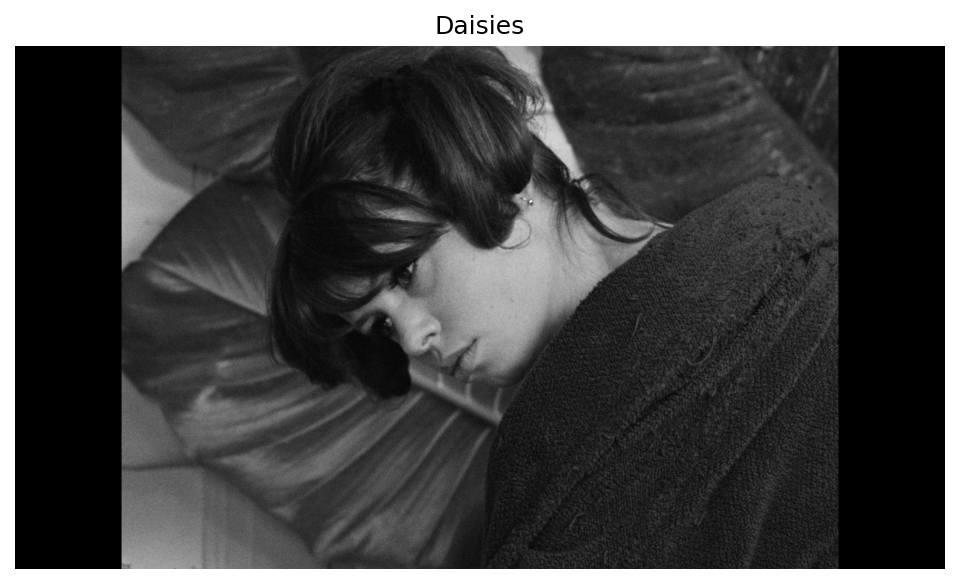

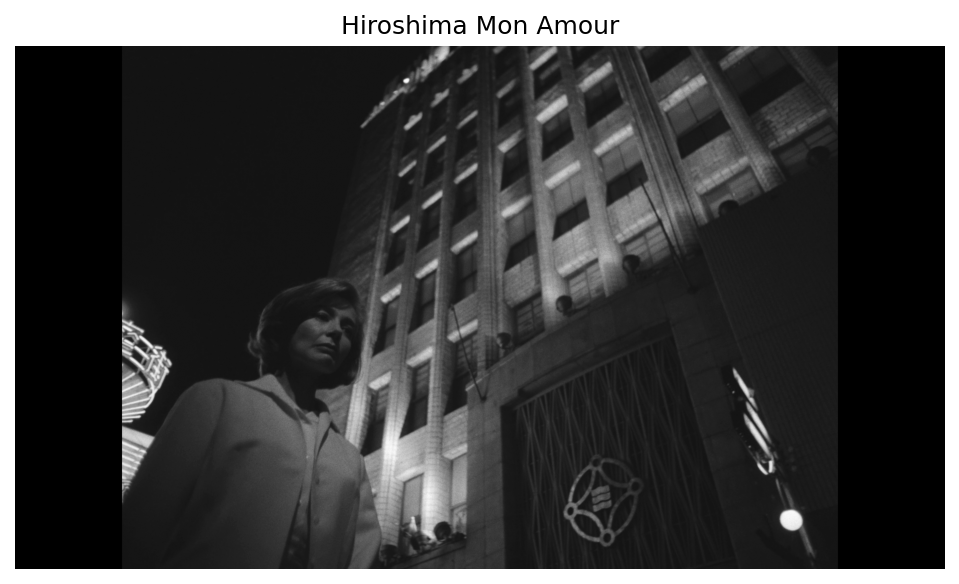

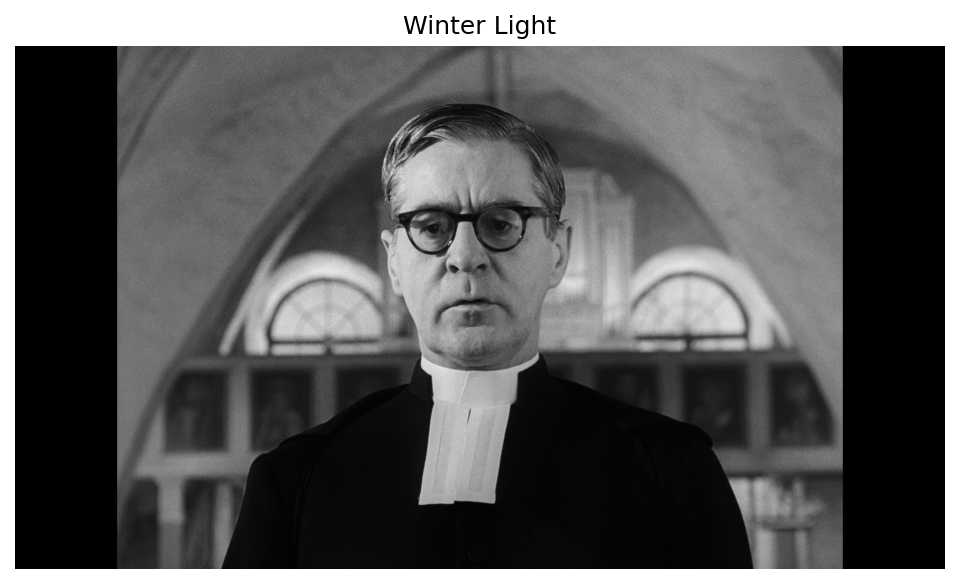

In [83]:
image_paths = ['Daisies.png', 'Hiroshima Mon Amour.png', 'Winter Light.png']

def load_images(path_to_images):
    """
    Loads images from the specified paths and converts them to grayscale.

    Parameters:
    path_to_images: List of image paths to load

    Returns:
    image_arrays: List of numpy arrays representing the grayscale images
    """
    image_arrays = []
    for path in path_to_images:
        try:
            image = Image.open(path)
            gray_image = image.convert('L')
            image_array = np.array(gray_image)
            image_arrays.append(image_array)
        except FileNotFoundError:
            print(f"File not found: {path}")
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return image_arrays

loaded_images = load_images(image_paths)

# TODO: Plot the loaded images
for i, img in enumerate(loaded_images):
    plt.figure(figsize=(8, 8), dpi=150)
    plt.imshow(img, cmap='gray')
    plt.title(image_paths[i].split('.')[0])
    plt.axis('off')
    plt.show()

**Reconstruction of Image**

In order to compress images, we need to use fewer number of singular values in $Σ$. Write a function that reconstructs the input array given the percentage of singular values to keep.

In [88]:
def reconstruct_image(img, SVD_func, sp):
    """
    Reconstructs an image using Singular Value Decomposition (SVD).

    Parameters:
    img: Numpy array representing the input image
    SVD_func: Function to compute the SVD of the image
    sp: Percentage of singular values to keep (between 0 and 1)

    Returns:
    Reconstructed image as a numpy array
    """

    # Step 1: Perform SVD on the input image
    U, Sigma, V = SVD_func(img)

    # Step 2: Determine the number of significant singular values to keep
    # Set the insignificant singular values to zero
    shape = min(Sigma.shape[0], Sigma.shape[1])
    k = int(sp * shape)
    for i in range(k, shape):
        Sigma[i, i] = 0

    # Step 3: Reconstruct the image using the modified U, S, and V matrices
    reconstructed_img = np.dot(U, np.dot(Sigma, V.T))

    return np.clip(reconstructed_img, 0, 255)

Now reconstruct all the loaded images with ```sp = 0.04 ``` and plot them alongside the original images.

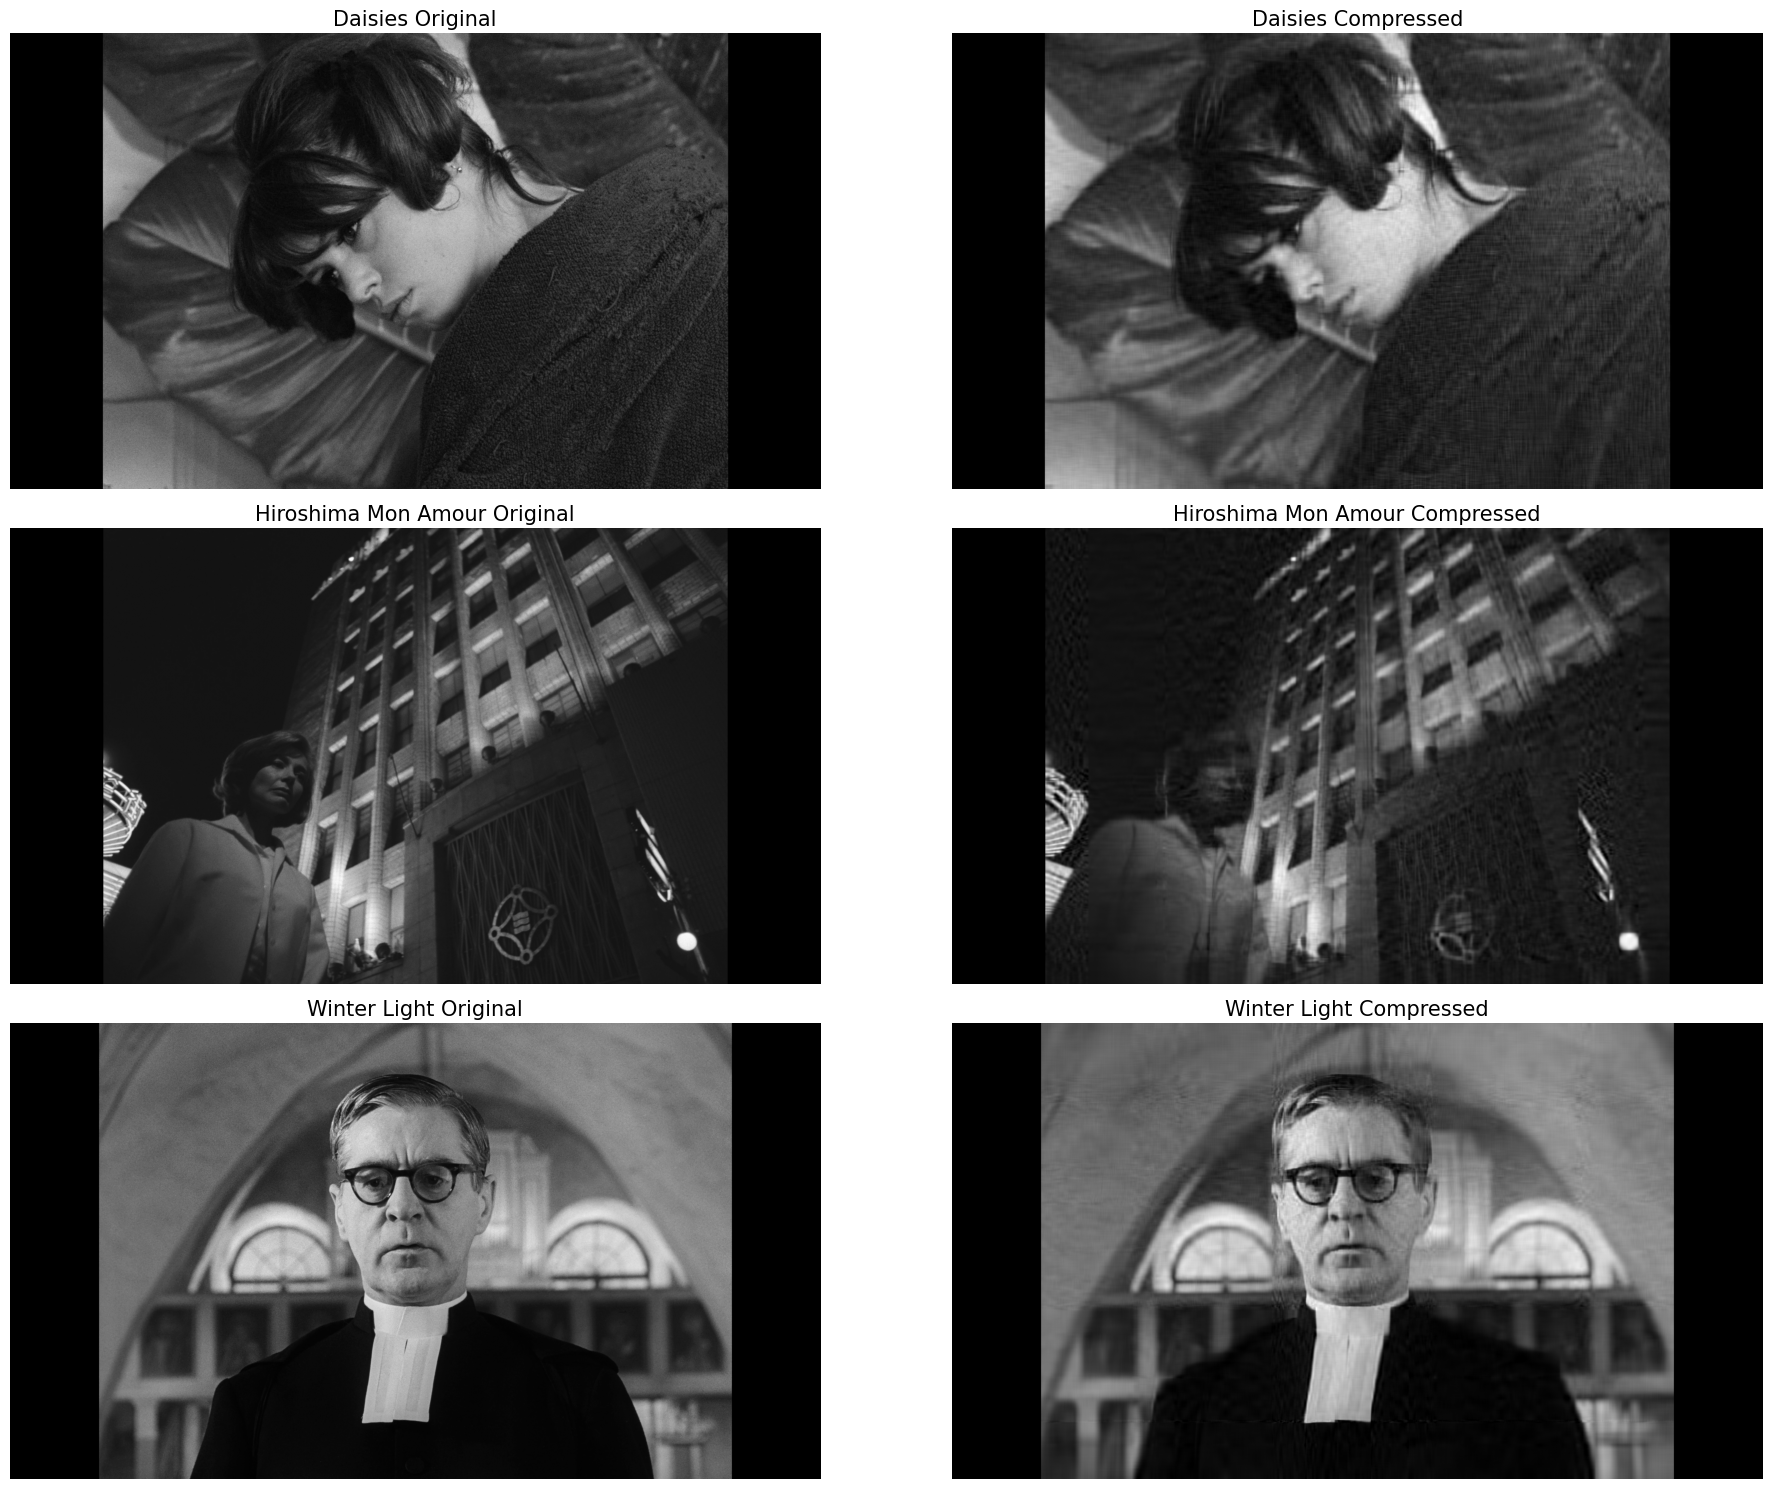

In [92]:
r_image = np.array([reconstruct_image(im, get_svd, 0.04) for im in loaded_images])
fig, axes = plt.subplots(len(loaded_images), 2, figsize=(20, 15))

plt.title('Original vs. Reconstructed Images', fontsize=20)
for i, (original, compressed) in enumerate(zip(loaded_images, r_image)):

    axes[i, 0].imshow(original, cmap='gray')
    axes[i, 0].set_title(f"{image_paths[i].split('.')[0]} Original", fontsize=15)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(compressed, cmap='gray')
    axes[i, 1].set_title(f"{image_paths[i].split('.')[0]} Compressed", fontsize=15)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

You can save the reconstructed images and compare their sizes with the respective original image.

In [93]:
for i in range(len(r_image)):
  plt.imsave(image_paths[i].split('.')[0] + '_compressed.png', r_image[i], cmap='gray')

Choose one of the images and plot the original image and the reconstructed images with ``` sp = [0.2, 0.1, 0.05, 0.03, 0.01] ```.

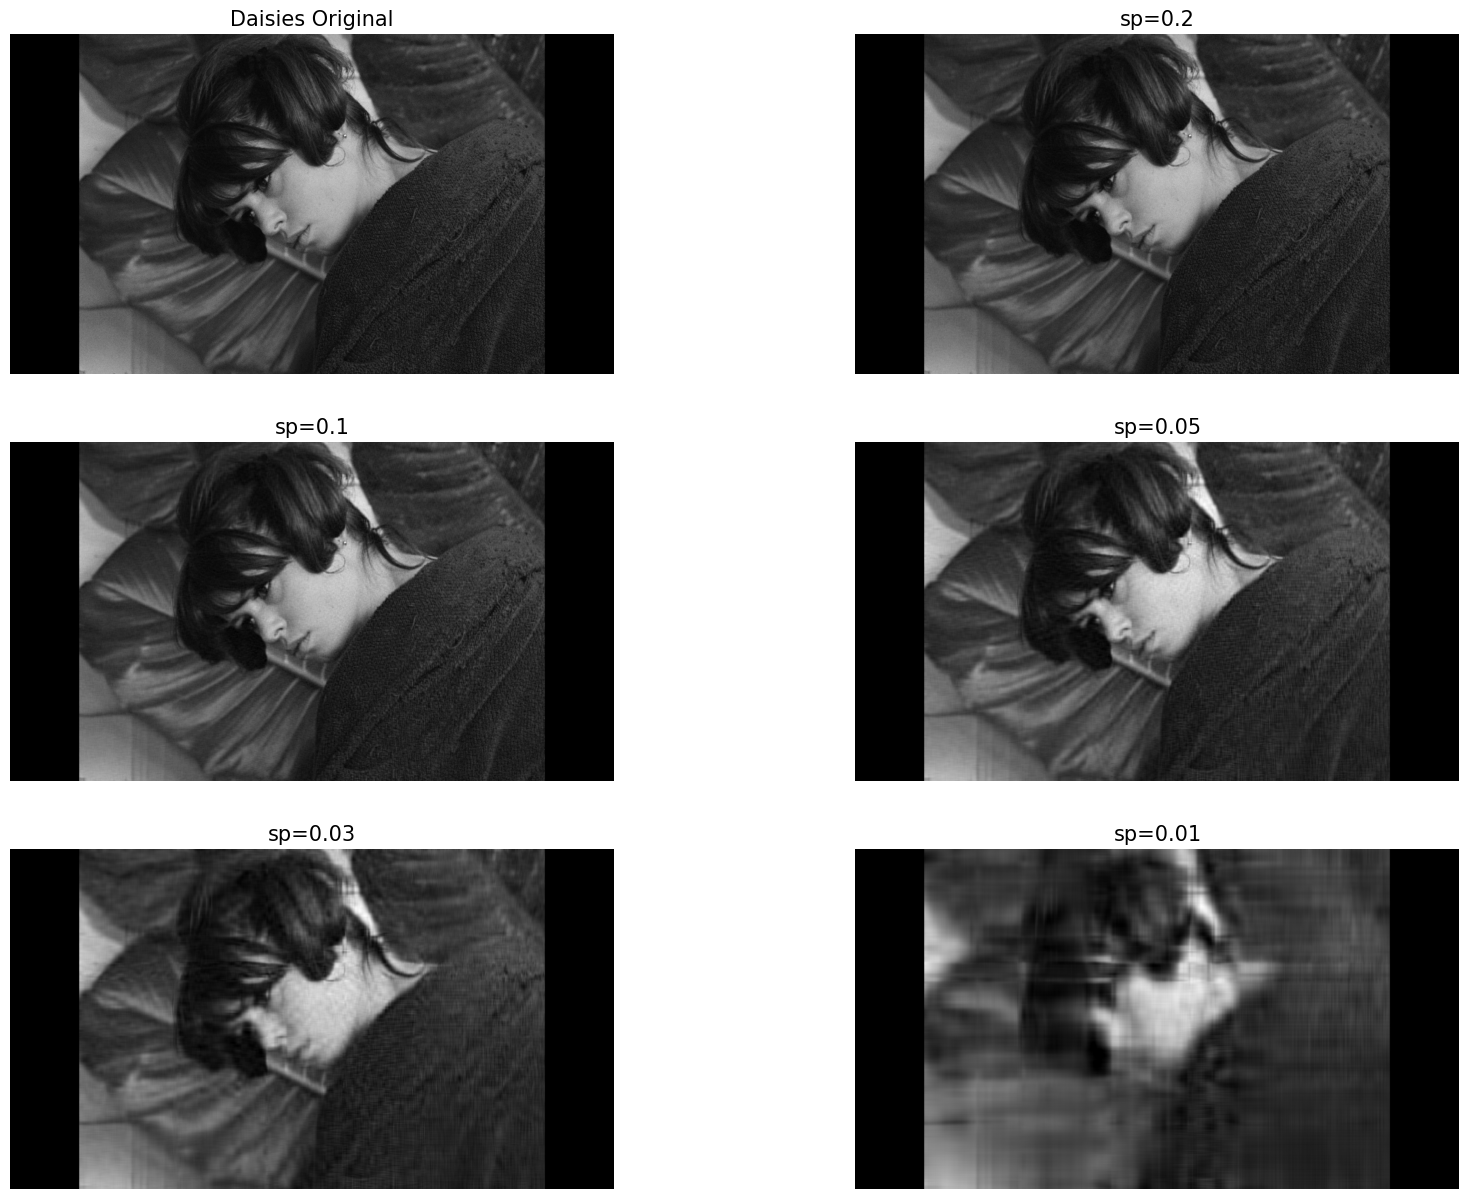

In [97]:
sps = [0.2, 0.1, 0.05, 0.03, 0.01]
re_image = np.array([reconstruct_image(loaded_images[0], get_svd, sp = s) for s in sps])

fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# TODO: Plot the original image and the reconstructed images with different number of singular values
axes[0, 0].imshow(loaded_images[0], cmap='gray')
axes[0, 0].set_title(image_paths[0].split('.')[0] + " Original", fontsize=15)
axes[0, 0].axis('off')

count = 0
for i in range(3):
    for j in range(2):
        if i == 0 and j == 0:
            continue
        axes[i, j].imshow(re_image[count], cmap='gray')
        axes[i, j].set_title(f"sp={sps[count]}", fontsize=15)
        axes[i, j].axis('off')
        count += 1
        if count >= len(sps):
            break

plt.show()

# **Latent Semantic Analysis**

In order to demonstrate another application of SVD, we use Latent Semantic Indexing/Analysis as a technique to find out how different words are related to each other.

**Environment Setup**

In [96]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.sparse.linalg import svds

**Downloading the Dataset**

For this task we will use ```fetch_20newsgroups``` dataset from ```scikit-learn``` package. This dataset contains about 20000 news documents categorized into 20 topics. We will be using 5 of them for convenience.

In [98]:
categories =  ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'sci.electronics', 'rec.sport.hockey']
random_state = 42
doc_text = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).data

**Data Transformation**

Since it is not possible to work directly with words, we need to transform the text into numerical data. The tool that will be used is ```TFidfVectorizer``` from scikit-learn that takes both occurrence frequency and importance into account and thus provides better results by focusing on informative words. Create a vectorizer of this type and transform the documents. Use 2000 features to increase efficiency.

In [99]:
max_features = 2000
stop_words = 'english'

# TODO: Initialize a TFidfVectorizer
vectorizer = TfidfVectorizer(max_features=max_features, stop_words=stop_words)

# TODO: Use the vectorizer to compute the IDF values on the documents and convert it to TF-IDF feature matrix
C = vectorizer.fit_transform(doc_text)

**Reconstruction**

Now apply SVD on matrix ```C``` and then reconstruct it using ```k = 5``` singular values. You will have to change the data type to ```np.float32``` first.

Notice: As you have probably realized, the manually implemented SVD does not follow an efficient algorithm for the decomposition. Since the matrix ```X``` is much larger than the matrices from the grayscale images, we will be using ```svds``` from ```scipy.sparse.linalg``` that can decompose sparse matrices much faster.

In [100]:
k = 5

# TODO: Convert the matrix datatype to np.float32
C = C.astype(np.float32)

# TODO: Perform SVD on the matrix using svds and the value of k and print the shape of V^T
U, S, Vt = svds(C, k=k)
print(Vt.shape)

(5, 2000)


Now extract the words from the vectorizer and save it. Then use the previously imported ```cosine_similarity``` to measure how related different words are. You can also see what feature names have been kept in the vectorizer.

In [104]:
# TODO: get the feature names from the vectorizer and save it in a document
terms = vectorizer.get_feature_names_out()

def word_similarity(word1, word2, terms, Vt):
    """
    Calculates the cosine similarity between two words based on their vector representations.

    Parameters:
    word1: First word for similarity comparison
    word2: Second word for similarity comparison
    terms: List of words corresponding to the feature names from the TF-IDF Vectorizer
    Vt: Transposed V matrix from the SVD of the TF-IDF matrix

    Returns:
    similarity: Cosine similarity between the two words (float) or None if one or both words are not found
    """

    # Step 1: Check if both words are in the terms list
    if word1 not in terms or word2 not in terms:
        return None  # Return None if either word is not found

    # Step 2: Get the indices of the words in the terms list
    idx1, idx2 = terms.tolist().index(word1), terms.tolist().index(word2)

    # Step 3: Retrieve the vectors for both words from the Vt matrix
    vec1, vec2 = Vt[:, idx1], Vt[:, idx2]

    # Step 4: Calculate the cosine similarity between the two vectors
    similarity = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

    return similarity

**Test Performance**

Output the similarity between the two words in each row and check if the measures are sensible.

In [105]:
word_mat = [['grade', 'average'],
            ['grade', 'horse'],
            ['horse', 'ride'],
            ['horse', 'programs'],
            ['programs', 'versions'],
            ['programs', 'toronto'],
            ['hockey', 'ice'],
            ['hockey', 'linux'],
            ['linux', 'windows'],
            ['linux', 'week']]

# TODO: print the similarity of each pair of words
for word1, word2 in word_mat:
    print(f"Similarity between '{word1:<8}' and '{word2:<8}':", word_similarity(word1, word2, terms, Vt))

Similarity between 'grade   ' and 'average ': 0.92371047
Similarity between 'grade   ' and 'horse   ': -0.4015804
Similarity between 'horse   ' and 'ride    ': 0.97603995
Similarity between 'horse   ' and 'programs': -0.478082
Similarity between 'programs' and 'versions': 0.959964
Similarity between 'programs' and 'toronto ': -0.24269834
Similarity between 'hockey  ' and 'ice     ': 0.9702092
Similarity between 'hockey  ' and 'linux   ': -0.14643495
Similarity between 'linux   ' and 'windows ': 0.9665308
Similarity between 'linux   ' and 'week    ': 0.06830937


### **PCA, Alternative Method**

Principal Component Analysis is another method that can be used for Latent Semantic Analysis. PCA is another dimensionality reduction technique commonly used in machine learning and statistical tasks to transform the data into a simpler space with new variables called principal components where it is easier to analyze data. PCA tries to cause the least loss of information in this process. Before performing PCA, the matrix must be in <b>mean-deviation form</b>. Suppose $[X_{1}, ..., X_{N}]$ is a $p \times N$ matrix of observations (a matrix in which the columns are different samples of data and the rows contain different pieces of information about that sample). The sample mean of $X$ is given by
$$
  M = \frac{1}{N}(X_{1} + ... + X_{N}).
$$
If $\hat{X}_{k}$ is defined as $\hat{X}_{k} = X_{k} - M$ then
$$
B = [\hat{X}_{1}, ..., \hat{X}_{N}]
$$
is in mean-deviation form.

The PCA objective is to find an orthogonal $p \times p$ matrix $P$ that determines the change of variable, $X = PY$ with the property that the new variables in $Y = [y_{1}, ..., y_{n}]^T$ are uncorrelated and are arranged in order of decreasing variance. These variables are then used to reduce the dimensionality of the input.

You can visit this [link](https://www.youtube.com/watch?v=FgakZw6K1QQ) for a better understanding of what PCA is and how it works.

First thing needed to be done is to create a dense array from the transformed matrix ```X```, since PCA works with dense arrays. Then use ```PCA``` on the dense array with 10 principal components. And finally transform the transpose of output.

In [106]:
# TODO: Convert the matrix into a dense array and initialize PCA, keeping 10 components
dense_C = C.toarray()
pca = PCA(n_components=10)

# TODO: Fit the PCA model with the matrix and reduce the dimensionality. Then print the shape of output.
C_pca = pca.fit_transform(dense_C.T)
print(C_pca.shape)

(2000, 10)


As the last step, use the same array of words (```word_mat```) to observe the performance of PCA.

In [107]:
# TODO: Print the similarity measure using the new matrix
for word1, word2 in word_mat:
    print(f"PCA Similarity between '{word1:<8}' and '{word2:<8}':", word_similarity(word1, word2, terms, C_pca.T))

PCA Similarity between 'grade   ' and 'average ': 0.23186244
PCA Similarity between 'grade   ' and 'horse   ': 0.03750788
PCA Similarity between 'horse   ' and 'ride    ': 0.3151998
PCA Similarity between 'horse   ' and 'programs': -0.2404456
PCA Similarity between 'programs' and 'versions': 0.53145784
PCA Similarity between 'programs' and 'toronto ': -0.35563895
PCA Similarity between 'hockey  ' and 'ice     ': 0.92466515
PCA Similarity between 'hockey  ' and 'linux   ': -0.44328
PCA Similarity between 'linux   ' and 'windows ': 0.75063497
PCA Similarity between 'linux   ' and 'week    ': -0.17567271


Compare the result of PCA and SVD for the LSA task based the similarity measure you used. Which one captures the connections between words better? Based on the sparse nature of term-document matrices, explain why this difference in performance appears despite the close relation of PCA and SVD.

---

SVD outperforms PCA in capturing semantic relationships between words in the **LSA** task. The results demonstrate that **SVD** assigns higher similarity scores to related words (e.g., **hockey** and **ice** with a score of 0.97) and assigns lower, more negative similarity scores to unrelated words (e.g., **hockey** and **linux** with -0.44). In comparison, **PCA** produces relatively lower similarity scores for related words (e.g., **hockey** and **ice** with 0.92) and is less effective in distinguishing unrelated words.

The reason for this difference lies in the **sparse nature** of term-document matrices commonly used in text analysis. **SVD**, through its singular value decomposition process, is designed to extract **latent semantic structures**, which help in preserving both **direct** and **indirect** relationships between words. SVD is better suited to handle sparse data because it focuses on capturing these underlying structures even when direct word co-occurrences are infrequent.

On the other hand, **PCA**, which uses eigenvalue decomposition to maximize the variance in the data, does not prioritize semantic connections. Instead, it focuses on identifying the directions of maximum variance, which does not always align with the meaningful relationships between words. PCA is less adept at handling sparse data because it does not account for the indirect associations between words, leading to weaker semantic modeling.

Thus, while both **PCA** and **SVD** are mathematically related, **SVD** is more effective in preserving the semantic structure of the data and handling sparse term-document matrices. This explains why SVD produces stronger results in tasks such as **LSA**, where capturing indirect word associations and semantic meaning is crucial.